# OpenCV Tracking based on HSV - Colorspace


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Capture from a Camera
This example shows how to track an object based on HSV thresholds. It will track a blue object and draw the tracking points from the last 30 positions.

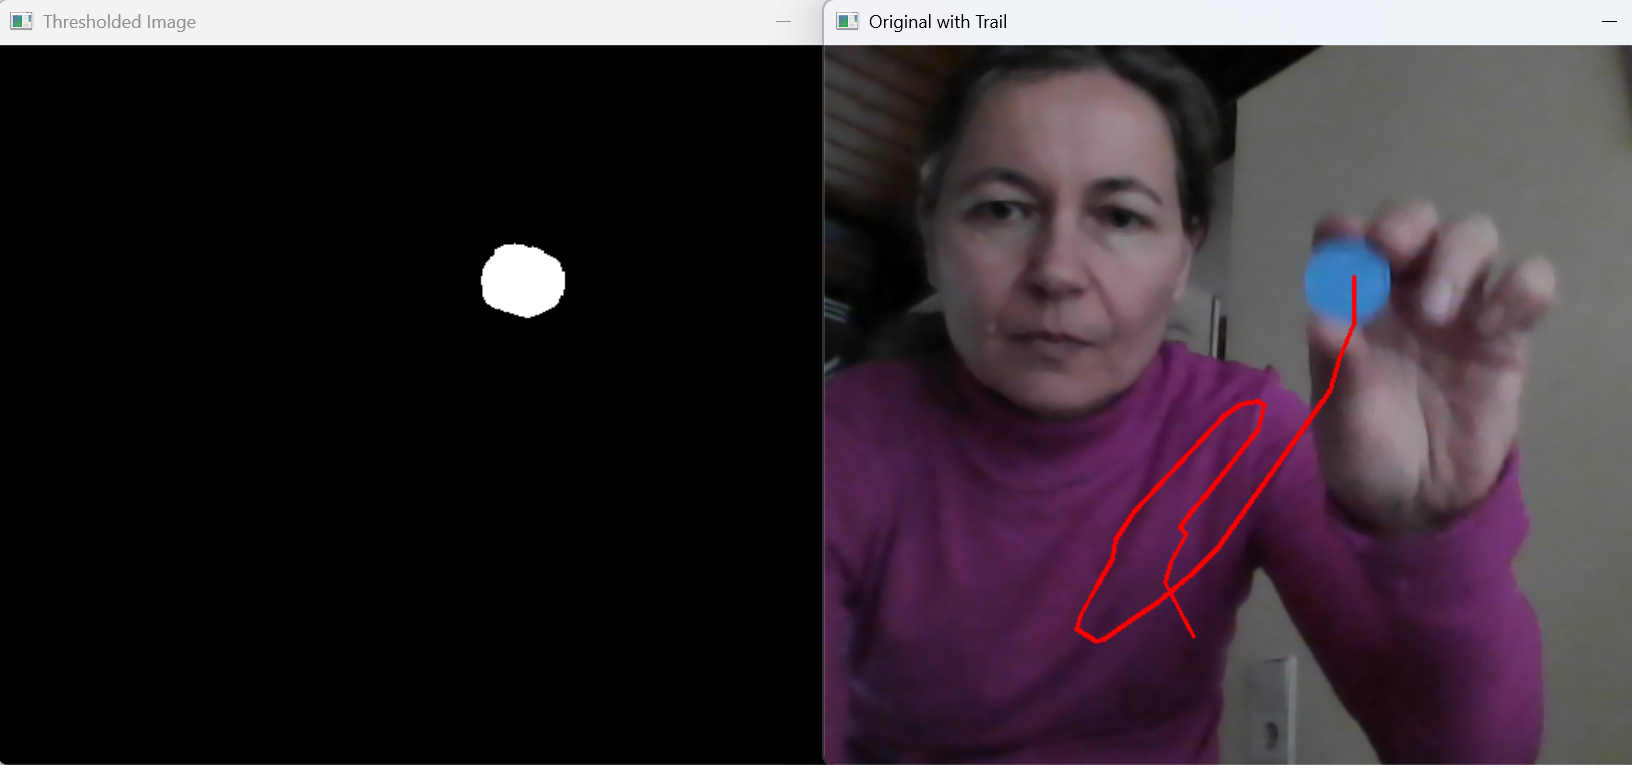

In [3]:
from IPython.display import display, Image, clear_output
import time

from collections import deque

def nothing(x):
    pass

# Capture the video from webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Cannot open webcam")
    exit()

cv2.namedWindow("Control")

# Create trackbars for HSV thresholds
cv2.createTrackbar("LowH", "Control", 100, 255, nothing)
cv2.createTrackbar("HighH", "Control", 140, 255, nothing)

cv2.createTrackbar("LowS", "Control", 150, 255, nothing)
cv2.createTrackbar("HighS", "Control", 255, 255, nothing)

cv2.createTrackbar("LowV", "Control", 60, 255, nothing)
cv2.createTrackbar("HighV", "Control", 255, 255, nothing)


# Grab a temporary frame to determine size
ret, imgTmp = cap.read()
imgLines = np.zeros_like(imgTmp)
# Store last 30 positions
pts = deque(maxlen=30)
while True:
    ret, imgOriginal = cap.read()
    if not ret:
        print("Cannot read a frame from video stream")
        break

    imgHSV = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2HSV)

    # Get trackbar positions
    iLowH = cv2.getTrackbarPos("LowH", "Control")
    iHighH = cv2.getTrackbarPos("HighH", "Control")

    iLowS = cv2.getTrackbarPos("LowS", "Control")
    iHighS = cv2.getTrackbarPos("HighS", "Control")

    iLowV = cv2.getTrackbarPos("LowV", "Control")
    iHighV = cv2.getTrackbarPos("HighV", "Control")

    # Thresholding
    imgThresholded = cv2.inRange(
        imgHSV,
        (iLowH, iLowS, iLowV),
        (iHighH, iHighS, iHighV)
    )

    # Morphological opening
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    imgThresholded = cv2.erode(imgThresholded, kernel)
    imgThresholded = cv2.dilate(imgThresholded, kernel)

    # Morphological closing
    imgThresholded = cv2.dilate(imgThresholded, kernel)
    imgThresholded = cv2.erode(imgThresholded, kernel)

    # Calculate moments
    moments_val = cv2.moments(imgThresholded)
    dArea = moments_val["m00"]
    #print(f"Area: {dArea}")
    # Only track if area > threshold
    if dArea > 10000:
        posX = int(moments_val["m10"] / dArea)
        posY = int(moments_val["m01"] / dArea)
        pts.append((posX, posY))
        # redraw only the last 10 points
        for i in range(1, len(pts)):
            if pts[i - 1] is None or pts[i] is None:
                continue
            cv2.line(imgOriginal, pts[i - 1], pts[i], (0, 0, 255), 2)

   
    # combine original frame and the persistent lines overlay so trail is visible
    # use addWeighted to avoid clipping issues and ensure visibility
    overlay = cv2.addWeighted(imgOriginal, 1.0, imgLines, 1.0, 0)

    cv2.imshow("Thresholded Image", imgThresholded)
    cv2.imshow("Original with Trail", overlay)
    # Exit on ESC
    if cv2.waitKey(30) & 0xFF == 27:
        print("ESC key pressed by user")
        break

cap.release()
cv2.destroyAllWindows()


ESC key pressed by user
